In [4]:
import pandas as pd
import os
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from termcolor import *

In [84]:
def preprocess(df):
    # Drop temp_R, R_precision and matching_score_pred columns
    df = df.drop(columns=['temp_R', 'R_precision', 'matching_score_pred'])

    # Remove first 4 characters of token column in dataframe (removes sos/ from token string)
    df['token'] = df['token'].str[4:]

    # Replace every '/' with ' ' in token column
    df['token'] = df['token'].str.replace('/', ' ')

    # Remove all words that end with a '_' in token column
    df['token'] = df['token'].str.replace(r'\w*_', '', regex=True).str.strip()

    # Remove everything after and including eos (probably stands for end of sentence) in token column
    df['token'] = df['token'].str.split('eos').str[0]

    return df

# --- Load data ---
# Load altered.log and original.log, split with ; into dataframes
original = pd.read_csv('original.log', sep=';')
altered = pd.read_csv('altered.log', sep=';')

# --- Preprocess data ---
original = preprocess(original)
altered = preprocess(altered)

# Add suffix to columns
original = original.add_suffix('_original')
altered = altered.add_suffix('_altered')

# Fuse the two dataframes together
fused = pd.concat([original, altered], axis=1)

# Remove prefix
# Get the length of each token_original
fused['token_original_length'] = fused['token_original'].str.len()

# Remove the characters from the token_altered column based on the length of token_original
fused['token_altered_no_prefix'] = fused.apply(lambda row: row['token_altered'][row['token_original_length']:], axis=1)

fused.drop(columns=['token_original_length'], inplace=True)

# Shuffle column order
fused = fused[['temp_match_original', 'temp_match_altered', 'token_original', 'token_altered', 'token_altered_no_prefix']]

# Save fused dataframe to csv
fused.to_csv('fused.csv', index=False)

In [85]:
fused

,temp_match_original,temp_match_altered,token_original,token_altered,token_altered_no_prefix
0,6.607329,3.061639,a man step forward hold an object to his head ...,a man step forward hold an object to his head ...,He do so by shift his
1,2.563857,3.117645,a person clap four time,a person clap four time They do so by quickly ...,They do so by quickly bring their hand togethe...
2,8.381577,3.895031,a man crouch and punch the air with his left h...,a man crouch and punch the air with his left h...,He does so by swiftly bend his knee and
3,1.214417,2.360865,a man is lift his left arm,a man is lift his left arm He do so by raise h...,He do so by raise his left arm upwards
4,5.342271,5.676783,a man is run with arm at side,a man is run with arm at side They do so by rh...,They do so by rhythmically swinge their arm ba...
...,...,...,...,...,...
4635,2.508567,1.858373,a person make several large circle with both a...,a person make several large circle with both a...,ey do so by rotate
4636,3.051218,3.349486,a person hold something and sweep the floor wi...,a person hold something and sweep the floor wi...,They do so by bend and extend their arm in
4637,2.510017,0.881602,a person take a side step to thoer right then ...,a person take a side step to thoer right then ...,They do
4638,2.070766,2.387809,a seated person motion in a come here movement...,a seated person motion in a come here movement...,They do so by extend and curl


Mean Org.: 2.9171777724094823
Mean Alt.: 3.2274972132586193
Altered worse than original: 1905
Original worse than altered: 2734


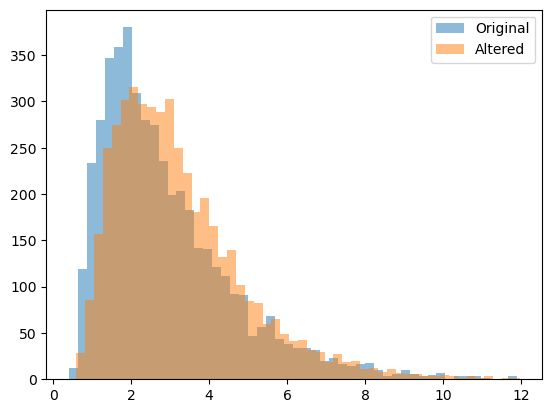

In [118]:
# --- Analysis ---
fused = pd.read_csv('fused.csv')

# Replace NaN values with empty string
fused = fused.fillna('')

print(f"Mean Org.: {fused['temp_match_original'].mean()}")
print(f"Mean Alt.: {fused['temp_match_altered'].mean()}")

improvements = fused[fused['temp_match_altered'] < fused['temp_match_original']]
degradations = fused[fused['temp_match_altered'] > fused['temp_match_original']]

# Figure out how many times the altered temp_match is higher than the original and vice-versa
print(f"Altered worse than original: {len(improvements)}")
print(f"Original worse than altered: {len(degradations)}")

# Create histogram of temp_match_original and temp_match_altered
import matplotlib.pyplot as plt

plt.hist(fused['temp_match_original'], bins=50, alpha=0.5, label='Original')
plt.hist(fused['temp_match_altered'], bins=50, alpha=0.5, label='Altered')
plt.legend(loc='upper right')
plt.show()

In [119]:
improvements['diff'] = improvements['temp_match_original'] - improvements['temp_match_altered']
degradations['diff'] = degradations['temp_match_altered'] - degradations['temp_match_original']

# Sort by diff
improvements = improvements.sort_values(by='diff', ascending=False)
degradations = degradations.sort_values(by='diff', ascending=False)

cprint('Top 10 improvements', 'green', attrs=['bold'])
for i in range(10):
    print(colored("Original token: ", 'blue') + improvements['token_original'].iloc[i])
    try:
        print(colored("Added info: ", 'blue') + improvements['token_altered_no_prefix'].iloc[i])
    except:
        print(colored("Added info: ", 'blue') + "-")
    print(colored("Improvement: ", 'blue') + f"{improvements['diff'].iloc[i]}")
    print('\n')

Top 10 improvements
Original token: the sim extend arm out ward then take a sit in a cresscross fashion before stand up again 
Added info: They do 
Improvement: 10.3062003


Original token: a person quickly pace while look down 
Added info: They do so by briskly move their leg in a walk motion while 
Improvement: 9.490547800000002


Original token: stickman right hand wave five time with full motion from elbow to hand extension 
Added info: They do so by repeatedly bend 
Improvement: 9.3960683


Original token: a man go from have his hand up ready to fight with left foot forward to kneel on his right 
Added info: 
Improvement: 8.547255700000001


Original token: person has arm out before lower and run quickly on the spot 
Added info:  They do so by quickly bring their arm 
Improvement: 8.263742899999999


Original token: the person throw some thing forward 
Added info: They do so by forcefully extend their arm forward 
Improvement: 7.300072899999999


Original token: a person is stand 

In [120]:
cprint('Top 10 degradations', 'red', attrs=['bold'])
for i in range(10):
    print(colored("Original token: ", 'blue') + degradations['token_original'].iloc[i])
    try:
        print(colored("Added info: ", 'blue') + degradations['token_altered_no_prefix'].iloc[i])
    except:
        print(colored("Added info: ", 'blue') + "-")
    print('\n')

Top 10 degradations
Original token: a figure kick and then wipe their chin 
Added info: They do so by quickly lift and extend their leg and then 


Original token: a person walk in a s shape 
Added info: They do so by sway their hip from side to side 


Original token: a person walk back and forth and every so often duck down to the side suddenly 
Added info: They do so by 


Original token: a person is stand and step backwards 
Added info: They do so by push off their front foot and shift their weight 


Original token: a person walk straight go slightly to the left 
Added info:  They do so by alternately swinge their arm and leg in 


Original token: a person walk forward and pick thing up and put them down with their hand 
Added info: They do so by alternate 


Original token: a person stand on one foot hold their left hand up while move their right foot in a side to 
Added info: 


Original token: the man is sit down and stand up 
Added info: He do so by extend his leg and push his

In [121]:
# Find the most common words in the token_altered_no_prefix column
from collections import Counter

words = []
for i in range(len(fused)):
    words.extend(fused.iloc[i]['token_altered_no_prefix'].split(' '))

counter = Counter(words)
print(counter.most_common(20))

[('', 4741), ('do', 3624), ('so', 3596), ('by', 3460), ('They', 3368), ('their', 2535), ('and', 1571), ('leg', 711), ('arm', 678), ('the', 505), ('forward', 441), ('extend', 438), ('with', 424), ('to', 424), ('alternately', 412), ('step', 369), ('He', 367), ('in', 357), ('swinge', 335), ('move', 319)]


In [130]:
keywords = ['leg', 'arm', 'torso', 'knee', 'hip', 'elbow', 'hand', 'forward', 'extend', 'swinge', 'move']

for keyword in keywords:
    print(f"Keyword: {keyword}")
    print(f"Improvements: {improvements['token_altered_no_prefix'].str.contains(keyword).sum()}")
    print(f"Degradations: {degradations['token_altered_no_prefix'].str.contains(keyword).sum()}")
    total_improvement = improvements[improvements['token_altered_no_prefix'].str.contains(keyword)]['diff'].sum()
    total_degradation = degradations[degradations['token_altered_no_prefix'].str.contains(keyword)]['diff'].sum()
    print(f"Total improvement: {total_improvement}")
    print(f"Total degradation: {total_degradation}")
    print('\n')

Keyword: leg
Improvements: 200
Degradations: 514
Total improvement: 284.19560523
Total degradation: 842.9026425699999


Keyword: arm
Improvements: 321
Degradations: 364
Total improvement: 434.96044128
Total degradation: 463.3864424


Keyword: torso
Improvements: 28
Degradations: 53
Total improvement: 33.691913199999995
Total degradation: 94.89571557000002


Keyword: knee
Improvements: 40
Degradations: 56
Total improvement: 39.017938599999994
Total degradation: 60.22840167


Keyword: hip
Improvements: 15
Degradations: 38
Total improvement: 11.653988900000002
Total degradation: 65.8352578


Keyword: elbow
Improvements: 2
Degradations: 5
Total improvement: 2.4403941
Total degradation: 8.3685192


Keyword: hand
Improvements: 149
Degradations: 157
Total improvement: 192.0299642
Total degradation: 205.84527489000004


Keyword: forward
Improvements: 129
Degradations: 313
Total improvement: 201.23562310000003
Total degradation: 532.5265697899999


Keyword: extend
Improvements: 166
Degradations

In [163]:
# Get best and worst quantile (10%) based on temp_match from original for both original and altered prompts
original_good = fused[fused['temp_match_original'] < fused['temp_match_original'].quantile(0.1)]
original_bad =  fused[fused['temp_match_original'] > fused['temp_match_original'].quantile(0.9)]
altered_good = fused[fused['temp_match_altered'] < fused['temp_match_original'].quantile(0.1)]
altered_bad =  fused[fused['temp_match_altered'] > fused['temp_match_original'].quantile(0.9)]

cols_to_use = original_good.columns.difference(altered_good.columns) # This is essentially just the index

# We collect 4 classes:
# GG: Original good, Altered good
# GB: Original good, Altered bad
# BG: Original bad, Altered good
# BB: Original bad, Altered bad
GG = pd.merge(original_good, altered_good[cols_to_use], left_index=True, right_index=True, how='inner')
GB = pd.merge(original_good, altered_bad[cols_to_use], left_index=True, right_index=True, how='inner')
BG = pd.merge(original_bad, altered_good[cols_to_use], left_index=True, right_index=True, how='inner')
BB = pd.merge(original_bad, altered_bad[cols_to_use], left_index=True, right_index=True, how='inner')

GG[['token_original', 'token_altered_no_prefix']]

,token_original,token_altered_no_prefix
123,a person is do jump jack,ck They do so by repeatedly jump and move thei...
259,the person is jump up and down,They do so by repeatedly extend their leg to p...
384,a person jump multiple time,They do so by rapidly push off the ground with...
432,the person is jump up and down,They do so by rapidly push off the ground with...
634,a person jump in place,They do so by quickly extend their leg and pro...
...,...,...
4178,a person get down and crawl around the,They do so by bend their arm and knee and move...
4186,the person take side step to his left then sid...,They do so by step laterally
4368,a person is jump up repeatedly,They do so by push off the ground with both foot
4464,a person get down and crawl on all four,They do so by bend their arm and leg and move
